# Setting

In [1]:
# Import Libraries & Functions
from utility import *

In [2]:
# Turn off warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
# Visualization Setting
color_palette = 'Set3'
title_size = 20
sns.set_style("whitegrid")
plt.rcParams['font.family'] = 'NanumGothic'

# Import Data

In [4]:
path = os.path.join(os.path.dirname(os.getcwd()), "평가데이터", "데이터분석분야_챔피언스리그_수산Biz_고래왕_평가데이터.xlsx")

In [5]:
df_squid = pd.read_excel(path, usecols="A:C")
df_salmon = pd.read_excel(path, usecols="F:H")
df_shrimp = pd.read_excel(path, usecols="K:M")

In [6]:
df_train = pd.read_excel(os.path.join(os.getcwd(), 'DATA', 'train.xlsx'))

In [7]:
df_preprocessed = pd.read_csv(os.path.join(os.getcwd(), 'DATA', 'preprocessed_train_notencoded.csv'))
df_preprocessed2 = pd.read_csv(os.path.join(os.getcwd(), 'DATA', 'preprocessed_train_2.csv'))
df_weather_kr = pd.read_csv(os.path.join(os.getcwd(), 'DATA', 'preprocessed_weather_korea.csv'))
df_cpi = pd.read_csv(os.path.join(os.getcwd(), 'DATA', 'preprocessed_cpi.csv'))
df_weather = pd.read_csv(os.path.join(os.getcwd(), 'DATA', 'preprocessed_weather.csv'))

### add salmon weather data


In [8]:
df_nor = pd.read_csv(os.path.join(os.getcwd(), 'DATA', 'nor.csv'))

In [9]:
df_nor.rename(columns={'풍속': 'wind', '강수량': 'rain', '기온': 'temperature'}, inplace=True)
df_nor["CTRY_1"] = '노르웨이'
set_week(df_nor, '일자')

In [10]:
df_weather = pd.concat([df_weather, df_nor])

# 평가데이터 형태 조정

In [11]:
def set_like_train(df):
    df.rename(columns={df.columns[0]: 'CATEGORY_2', df.columns[1]: 'P_NAME', df.columns[2]: '일자'}, inplace=True)
    name = df['P_NAME'][0]  # 상세어종
    df_base = df_train[(df_train['P_NAME'] == name
                       ) &
                        # 제조국
                        ((df_train['CTRY_1'] == "칠레") |
                        (df_train['CTRY_1'] == "중국") |
                        (df_train['CTRY_1'] == "노르웨이") |
                        (df_train['CTRY_1'] == "태국") | 
                        (df_train['CTRY_1'] == "베트남")
                        ) & (
                        # 수출국
                        (df_train['CTRY_2'] == "칠레") |
                        (df_train['CTRY_2'] == "중국") | 
                        (df_train['CTRY_2'] == "노르웨이") |
                        (df_train['CTRY_2'] == "태국") | 
                        (df_train['CTRY_2'] == "베트남") |
                        (df_train['CTRY_2'] == "페루")
                        )]
    
    set_week(df, '일자')
    df['CATEGORY_1'] = df_base.CATEGORY_1.unique()[0]
    df['CATEGORY_2'] = df['CATEGORY_2'][0]
    df['P_NAME'] = name
    df['P_PURPOSE'] = df_base['P_PURPOSE'].value_counts().index[0]
    df['P_IMPORT_TYPE'] = df_base['P_IMPORT_TYPE'].value_counts().index[0]
    df['CTRY_1'] = df_base['CTRY_1'].value_counts().index[0]
    df['CTRY_2'] = df_base['CTRY_2'].value_counts().index[0]


In [12]:
set_like_train(df_squid)
set_like_train(df_salmon)
set_like_train(df_shrimp)

# Preprocessing

In [13]:
def preprocess(df):
    df_base = df_preprocessed[(df_preprocessed['P_NAME'] == df['P_NAME'][0]) &
                                       (df_preprocessed['CTRY_1'] == df['CTRY_1'][0]) &
                                       (df_preprocessed['CTRY_2'] == df['CTRY_2'][0]) &
                                       (df_preprocessed['P_PURPOSE'] == df['P_PURPOSE'][0])]
    # 파생변수 추가
    df['ctry1_cnt'] = df_base['ctry1_cnt'].iloc[0]
    df['purpose_cnt'] = df_base['purpose_cnt'].iloc[0]
    df['category1_cnt'] = df_base['category1_cnt'].iloc[0]
    df['category2_cnt'] = df_base['category2_cnt'].iloc[0]
    df['name_cnt'] = df_base['name_cnt'].iloc[0]
    df['is_processed'] = df_base['is_processed'].iloc[0]
    df['import_cnt'] = df_base['import_cnt'].mean()
    import_type_list = set()
    for tmp in df.P_IMPORT_TYPE.unique():
        for a in tmp.split(','):
            import_type_list.add(a)    
    for name in import_type_list:
        df[name] = 0
        df.loc[df['P_IMPORT_TYPE'].str.contains(name, regex=False), name] = 1

    # 데이터 추가
    df = pd.merge(df, df_weather_kr, on=['year', 'week'], how='left')
    df = pd.merge(df, df_weather, on=['year', 'week', 'CTRY_1'], how='left')
    df = pd.merge(df, df_cpi, on=['year', 'week'], how='left')

    # Grouping
    df['temp_kr'] = (df['temperature_kr'] + df['water_temp_kr']) / 2
    df['temp'] = (df['rain'] + df['temperature']) / 2
    
    # 정규화
    standardization = ['name_cnt', 'import_cnt', 'wind', ]
    standardization.extend(['wind', 'rain'])
    for column in standardization:
        df[column] = np.log1p(df[column])
        
    # Scaling
    df['temp_kr'] = (df['temp_kr'] - np.mean(df['temp_kr'])) / df['temp_kr'].std()
    df['temp'] = (df['temp'] - np.mean(df['temp'])) / df['temp'].std()
    
    # One Hot Encoding
    one_hot = ['CTRY_1', 'CTRY_2', 'P_PURPOSE', 'P_NAME', 'CATEGORY_1', 'CATEGORY_2']
    df = pd.get_dummies(df, columns=one_hot)
    
    # Drop
    drop_columns = ['cpi_fish', 'temperature_kr', 'water_temp_kr', 'rain', 'temperature', 'P_IMPORT_TYPE']
    df.drop(columns=drop_columns, axis=1, inplace=True)
    
    # Add other one-hot-encoded columns
    for column in df_preprocessed2.columns:
        if column == "P_PRICE":
            continue
        if column not in df.columns:
            df[column] = 0
    
    return df

In [14]:
df_squid = preprocess(df_squid)
df_salmon = preprocess(df_salmon)
df_shrimp = preprocess(df_shrimp)

### Prepare for LGBM

In [15]:
import re
df_squid = df_squid.rename(columns = lambda x:re.sub(',', '', x))
df_salmon = df_salmon.rename(columns = lambda x:re.sub(',', '', x))
df_shrimp = df_shrimp.rename(columns = lambda x:re.sub(',', '', x))
df_preprocessed2 = df_preprocessed2.rename(columns = lambda x:re.sub(',', '', x))

# Train model

In [16]:
models = []

### Gradient

In [17]:
model_gradient1 = GradientBoostingRegressor(learning_rate=0.01825, max_depth=1034, min_samples_split=4374, n_estimators=784, subsample=0.35)

In [18]:
model_gradient1.fit(df_preprocessed2.drop(columns=['P_PRICE'], axis=1), df_preprocessed2['P_PRICE'])

GradientBoostingRegressor(learning_rate=0.01825, max_depth=1034,
                          min_samples_split=4374, n_estimators=784,
                          subsample=0.35)

In [19]:
models.append(model_gradient1)

### XGBoost

In [20]:
model_xgb = XGBRegressor(n_estimators=500, min_child_weight=50, max_depth=25, learning_rate=0.012385)

In [21]:
model_xgb.fit(df_preprocessed2.drop(columns=['P_PRICE'], axis=1), df_preprocessed2['P_PRICE'])

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.012385, max_delta_step=0, max_depth=25,
             min_child_weight=50, missing=nan, monotone_constraints='()',
             n_estimators=500, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [22]:
models.append(model_xgb)

### LGBM

In [23]:
model_lgbm1 = LGBMRegressor(learning_rate=0.5, max_depth=2, min_child_samples=424,
                            min_child_weight=0.001, n_estimators=3338, num_leaves=2748)

In [24]:
model_lgbm1.fit(df_preprocessed2.drop(columns=['P_PRICE'], axis=1), df_preprocessed2['P_PRICE'])

LGBMRegressor(learning_rate=0.5, max_depth=2, min_child_samples=424,
              n_estimators=3338, num_leaves=2748)

In [25]:
models.append(model_lgbm1)

# Predict P_PRICE

In [26]:
# Predictions
squid, salmon, shrimp = [], [], []

In [27]:
for model in models:
    squid.append(model.predict(df_squid))

In [28]:
for model in models:
    salmon.append(model.predict(df_salmon))

In [29]:
for model in models:
    shrimp.append(model.predict(df_shrimp))

### Transform & Average out

In [30]:
def get_prediction(arr):
    return list(sum(list(np.expm1(arr[j][i]) for j in range(len(arr)))) / len(arr) for i in range(len(arr[0])))

In [31]:
squid_final = get_prediction(squid)
salmon_final = get_prediction(salmon)
shrimp_final = get_prediction(shrimp)

# Visualization

In [63]:
vis = pd.DataFrame(columns=['squid', 'salmon', 'shrimp'], )

In [74]:
for i in range(len(squid_final)):
    vis = vis.append({'squid': squid_final[i], 'salmon': salmon_final[i], 'shrimp': shrimp_final[i]}, ignore_index=True)

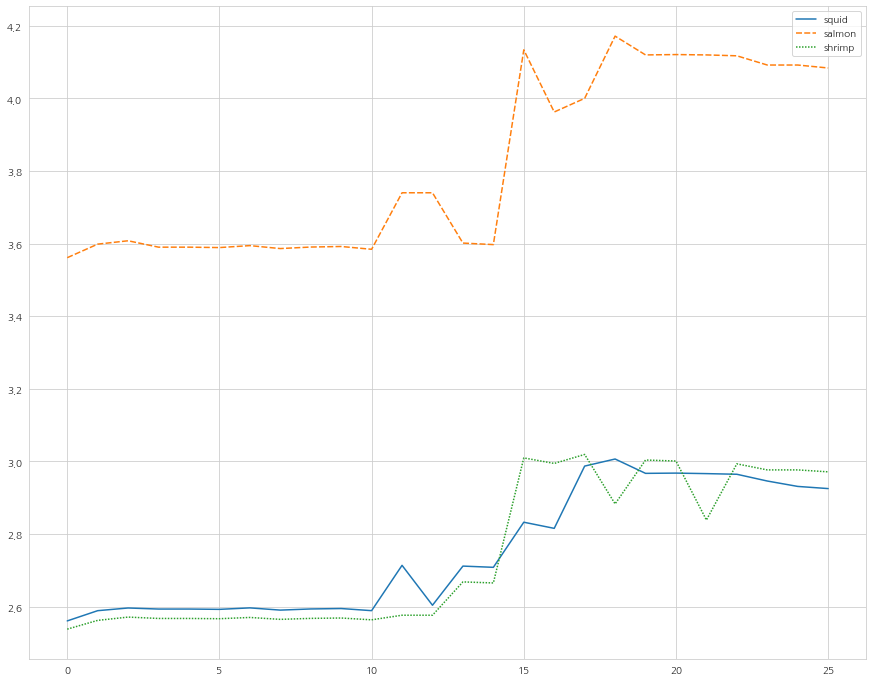

In [82]:
x = plt.figure(figsize=(15, 12))
sns.lineplot(data=vis)
save_img(x, "prediction")